In [81]:
%matplotlib inline

import numpy
import matplotlib.pyplot as plt
from collections import OrderedDict
from keras.datasets import imdb
from keras.preprocessing import sequence
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import helper
import models

numpy.set_printoptions(precision=3, threshold=1000, edgeitems=70, suppress=True)
numpy.random.seed(42)

In [63]:
# those params were found by the hyper parameter search shown below
default_params = {
        'top_words': 4000,             # only keep the top n frequent words from the dataset, zero the rest
        'max_review_length': 500,      # trim long and pad short reviews to be this exact length (in words)
        'embedding_vecor_length': 32,  # word embedding vector length
        'optimizer': 'adam',           # 'adam', 'sgd', etc.
        'epochs': 2,                   # number of training epoch (epoch = one pass on all training data)
        'batch_size': 128              # number of training examples used before updating weights in NN (affects memory and gradient decent convergence)
    }

# data is split by design into 50-50 train/test sets 
def reload_dataset(params = default_params):
    (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=params['top_words'])
    X = numpy.concatenate((X_train, X_test), axis=0)
    y = numpy.concatenate((y_train, y_test), axis=0)

reload_dataset()

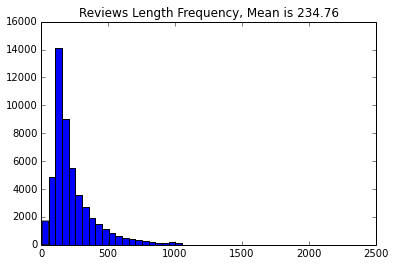

In [44]:
### Play a bit with the data ###
lengths = [len(x) for x in X]
plt.hist(lengths, bins=50)
plt.title("Reviews Length Frequency, Mean is %.2f" % numpy.mean(lengths))
plt.show()

In [25]:
def run_all(model, h_params, force_reload_data=False):
    # reload data only if we optimize the relevant hyper parameter (top_words) (it take a minute to load)
    global X_train, y_train, X_test, y_test
    if force_reload_data: reload_dataset(h_params)
    
    # trim and pad train & test sets
    X_train = sequence.pad_sequences(X_train, maxlen=h_params['max_review_length'])
    X_test = sequence.pad_sequences(X_test, maxlen=h_params['max_review_length'])
    
    # compile and define evaluation metrics
    model.compile(loss='binary_crossentropy', optimizer=h_params['optimizer'], metrics=['accuracy'])
    #print(model.summary())
    
    # fit
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=h_params['epochs'], batch_size=h_params['batch_size'], verbose=0)
    
    # evaluate
    scores = model.evaluate(X_test, y_test, verbose=0)
    # 
    #y_pred_proba = model.predict(X_test)
    #print(y_pred_proba)
    #fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba, pos_label=1)
    #roc_auc_score = metrics.roc_auc_score(y_test, y_pred)
    
    return (scores[1], history)

In [45]:
# to run the code on a specific model, with specific hyper parameters: 
# 1. create a method which retruns the model in models.py defining the model architecture
# 2. create your hyper parameters dictionary or use default_params (or overwrite some values)
# 3. call run_all with the model (from 1) and parameters (from 2). scores and run history will be retruned

score, history = run_all(models.base_model(default_params), default_params)
print("base model Accuracy: %.3f " % score)

base model Accuracy: 0.872 


In [ ]:
### Cross-validation and different train/test set ration ### 

In [55]:
# check whether score is consistent when trying Kfold and different split ratio (80-20)  

kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    score, history = run_all(models.base_model(default_params), default_params)
    print("base model Accuracy: %.3f " % score)
    
# reload original train test sets
reload_dataset()

base model Accuracy: 0.871 
base model Accuracy: 0.875 
base model Accuracy: 0.880 
base model Accuracy: 0.877 
base model Accuracy: 0.880 


In [22]:
#### hyper-parameteres optimization & search ####
# the method accepts a name of a hyper parameter to optimize and the possible value range to search on
# note: I did not do a grid search or tested across all combinations of hyper params because I believe
# this was not the purpose of the excercise. 
# what I did is search on one parameter, find its optimal value, fix it and move to the next

def test_hyper_parameter(name, range):
    scores = numpy.array([])

    for value in range:
        print ('### Testing %s = %s ... ###' % (name, value))
        new_params = dict(default_params.items() + {name: value}.items()) # is there a better way to do this in python??
        score, history = run_all(models.base_model(new_params), new_params, name == 'top_words')
        scores = numpy.append(scores, score)
        
    helper.plot_graph(range, scores, '%s - scores graph' %name, '%s' %name, 'scores')

### Testing top_words = 1000 ... ###
### Testing top_words = 2000 ... ###
### Testing top_words = 3000 ... ###
### Testing top_words = 4000 ... ###
### Testing top_words = 5000 ... ###
### Testing top_words = 6000 ... ###
### Testing top_words = 7000 ... ###
### Testing top_words = 8000 ... ###


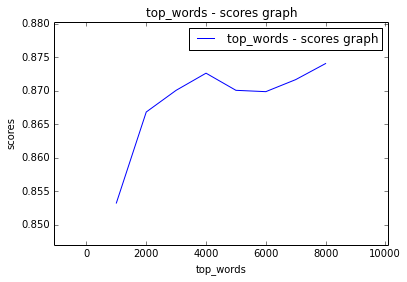

In [65]:
test_hyper_parameter('top_words', numpy.arange(1000, 8001, 1000))

### Testing max_review_length = 100 ... ###
### Testing max_review_length = 200 ... ###
### Testing max_review_length = 300 ... ###
### Testing max_review_length = 400 ... ###
### Testing max_review_length = 500 ... ###
### Testing max_review_length = 600 ... ###
### Testing max_review_length = 700 ... ###
### Testing max_review_length = 800 ... ###


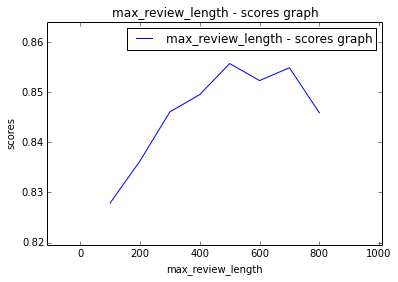

In [36]:
test_hyper_parameter('max_review_length', numpy.arange(100, 801, 100))

### Testing embedding_vecor_length = 8 ... ###
### Testing embedding_vecor_length = 16 ... ###
### Testing embedding_vecor_length = 32 ... ###
### Testing embedding_vecor_length = 64 ... ###


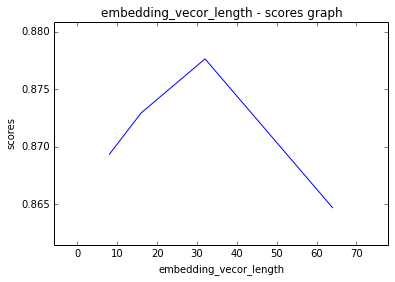

In [30]:
test_hyper_parameter('embedding_vecor_length', [8, 16, 32, 64])

### Testing optimizer = sgd ... ###
### Testing optimizer = adam ... ###


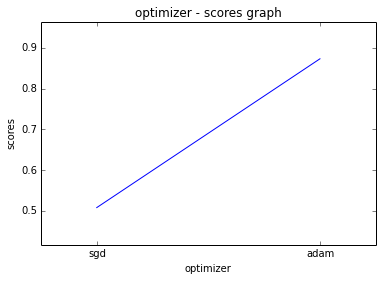

In [29]:
test_hyper_parameter('optimizer', ['sgd', 'adam'])

### Testing epochs = 1 ... ###
### Testing epochs = 2 ... ###
### Testing epochs = 3 ... ###
### Testing epochs = 4 ... ###
### Testing epochs = 5 ... ###


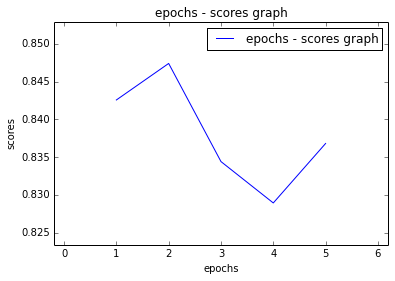

In [46]:
test_hyper_parameter('epochs', [1, 2, 3, 4, 5])

### Testing batch_size = 32 ... ###
### Testing batch_size = 64 ... ###
### Testing batch_size = 128 ... ###
### Testing batch_size = 256 ... ###
### Testing batch_size = 512 ... ###


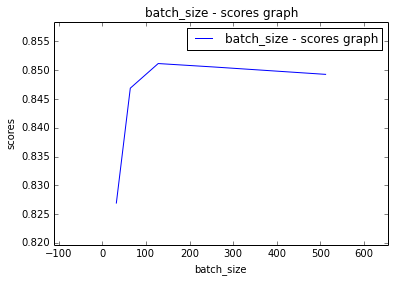

In [53]:
test_hyper_parameter('batch_size', [32, 64, 128, 256, 512])

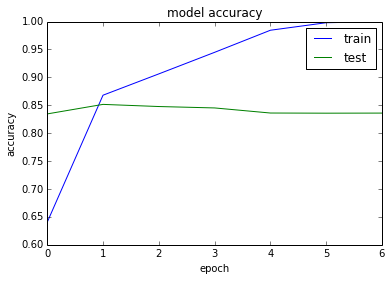

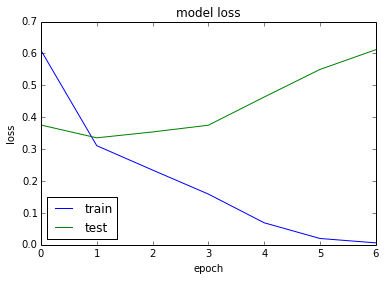

In [64]:
### Visualizing Model Training History ###
# plot accuracy and loss history of the model training 
# we can see the model overfits very fast. training beyond epoch 3 makes the test loss get bigger drastically

new_params = dict(default_params.items() + {'epochs': 7}.items())
scores, history = run_all(models.base_model(new_params), new_params)

helper.plot_several([history.history['acc'], history.history['val_acc']], ['train', 'test'], 'model accuracy', 'epoch', 'accuracy')
helper.plot_several([history.history['loss'], history.history['val_loss']], ['train', 'test'], 'model loss', 'epoch', 'loss')

In [90]:
# tests different models (defined in models.py), then compares them
def test_models():
    
    # define the parameters for the different models
    model1_params = default_params
    model2_params = default_params
    model3_params = dict(default_params.items() + {'epochs': 1, 'batch_size': 64}.items())     
    model4_params = dict(default_params.items() + {'embedding_vecor_length': 128, 'epochs': 4, 'batch_size': 32}.items())
    
    # loop over the models with their corresponding params and run them saving the score for each one
    scores = []
    models_data = OrderedDict({'base': {'model': models.base_model(model1_params), 'params': model1_params}})
    models_data['conv']    = {'model': models.conv_model(model2_params),    'params': model2_params}
    models_data['lstm']    = {'model': models.lstm_model(model3_params),    'params': model3_params}
    models_data['lstm-bi'] = {'model': models.bi_lstm_model(model4_params), 'params': model4_params}

    for model_name, model_data in models_data.iteritems():
        model_obj = model_data['model']
        model_params = model_data['params']
        print("Training Model '%s' ... " % model_name),
        score, history = run_all(model_obj, model_params)
        scores.append(score)
        print("Accuracy: %.3f " % score)
    
    helper.plot_graph(x_values=models_data.keys(), y_values=scores, title='Model Comparison', ylabel='Accuracy', type='ro')

In [ ]:
test_models()

Training Model 'base' ...  Accuracy: 0.871 
Training Model 'conv' ...  Accuracy: 0.888 
Training Model 'lstm' ... 

In [26]:
# I found something interesting in a post describing how to use pre-trained word embeddings named "GloVe embeddings".
# https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

# Instead of training the embeddings layer ourselves on our "small" dataset, GloVe was trained on 400k dump of 
# English wikipedia.
# Eventually, I chose not to implement this because that will require the use of the original (and not tokenized) 
# dataset which I've been given in the exercise. I figured this implementation will be pretty time consuming, 
# and may not align with the purpose of this excersice